In [1]:
import cv2
import numpy as np
from skimage import transform, registration, exposure
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from pystackreg import StackReg
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.metrics import mean_squared_error
import ants
from pystackreg import StackReg
import subprocess
import itk
import pandas as pd

from skimage import exposure, filters

prefix = "./"

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [17]:

def composite_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs



def composite_images(imgs, equalize=False, aggregator=np.mean, enhance_contrast=True, line_thickness=3):
    # Optionally equalize histogram for all images
    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    # Normalize the images to the range [0, 1]
    imgs = [img / img.max() for img in imgs]

    # If less than 3 images, pad with black images to form an RGB composite
    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3 - len(imgs))

    # Optionally enhance contrast of each image
    """
    if enhance_contrast:
        imgs = [exposure.rescale_intensity(img, in_range='image', out_range=(0, 1)) for img in imgs]
    """
    # Stack the images to form a composite (RGB)
    composite = np.dstack(imgs[:3])  # Use only the first 3 images for RGB

    # Apply thicker colored lines by enhancing edges
    edges = [filters.sobel(img) for img in imgs[:3]]  # Detect edges
    for i in range(3):
        composite[:, :, i] = np.clip(composite[:, :, i] + line_thickness * edges[i], 0, 1)

    return composite

# Function to apply edge detection and blur
def apply_blur_and_edges(image, lower = 3, upper = 50):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred_image, lower, upper)
    dilated_edges = cv2.dilate(edges, None, iterations=1)
    return dilated_edges


def manual_registration(img1, img2, points_img1, points_img2):
    # Convert points to numpy arrays
    pts_img1 = np.array(points_img1, dtype=np.float32)
    pts_img2 = np.array(points_img2, dtype=np.float32)
    
    # Compute the affine transformation matrix
    affine_matrix = cv2.getAffineTransform(pts_img1, pts_img2)
    
    # Apply the affine transformation to img1
    aligned_img1 = cv2.warpAffine(img1, affine_matrix, (img2.shape[1], img2.shape[0]))
    
    return aligned_img1

def plot_points_on_images(img1, img2, points_img1, points_img2):
    # Convert images to RGB for plotting
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    
    # Draw the points on img1
    for (x, y) in points_img1:
        cv2.circle(img1_rgb, (x, y), 10, (255, 0, 0), -1)  # Larger blue circles
    
    # Draw the points on img2
    for (x, y) in points_img2:
        cv2.circle(img2_rgb, (x, y), 10, (0, 0, 255), -1)  # Larger red circles
    
    # Plot both images with points
    plt.figure(figsize=(20, 20))  # Increase the figure size
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1_rgb)
    plt.title('Points on Image 1')
    
    plt.gca().set_xticks(np.arange(0, img1.shape[1], 100))  # Grid every 100 pixels in x direction
    plt.gca().set_yticks(np.arange(0, img1.shape[0], 100))  # Grid every 100 pixels in y direction
    plt.grid(True, which='both', color='green', linestyle='--', linewidth=0.5)  # Custom grid
    plt.xticks(rotation=90)  # Rotate xticks 90 degrees

    plt.subplot(1, 2, 2)
    plt.imshow(img2_rgb)
    plt.title('Points on Image 2')
    
    # Add grid
    plt.gca().set_xticks(np.arange(0, img2.shape[1], 100))  # Grid every 100 pixels in x direction
    plt.gca().set_yticks(np.arange(0, img2.shape[0], 100))  # Grid every 100 pixels in y direction
    plt.grid(True, which='both', color='green', linestyle='--', linewidth=0.5)  # Custom grid
    plt.xticks(rotation=90)  # Rotate xticks 90 degrees

    plt.show()



def register_elastix(fixed_img, moving_img):
    # Create a parameter object for the registration process
    parameter_object = itk.ParameterObject.New()

    # Add different transformation models to the parameter object
    parameter_map_translation = parameter_object.GetDefaultParameterMap('translation')
    parameter_object.AddParameterMap(parameter_map_translation)

    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)

    parameter_map_affine = parameter_object.GetDefaultParameterMap('affine', 8)
    parameter_object.AddParameterMap(parameter_map_affine)

    # Call the ITK Elastix registration method
    result_image, result_transform_parameters = itk.elastix_registration_method(
        np.asarray(fixed_img).astype(np.float32), 
        np.asarray(moving_img).astype(np.float32),
        parameter_object=parameter_object,
        log_to_console=False
    )
    
    return result_image, result_transform_parameters




# Improved function to apply an Elastix transformation to an image
def apply_elastix_transform(moving_img, fixed_img_shape, transform_parameters):
    # Create an ITK Transformix Filter
    transformix_filter = itk.TransformixFilter.New(np.asarray(moving_img).astype(np.float32))
    
    # Set the transformation parameters from Elastix
    transformix_filter.SetTransformParameterObject(transform_parameters)

    # Run the transformation
    transformix_filter.Update()

    # Get the transformed image
    transformed_image = transformix_filter.GetOutput()
    return np.array(transformed_image)


def apply_elastix_transform(moving_img, fixed_img_shape, transform_parameters):
    # Convert the moving image to the required format for ITK
    moving_img_itk = itk.image_from_array(np.asarray(moving_img).astype(np.float32))

    # Create an ITK Transformix Filter
    transformix_filter = itk.TransformixFilter.New(moving_img_itk)
    
    # Set the transformation parameters from Elastix
    transformix_filter.SetTransformParameterObject(transform_parameters)

    # Run the transformation
    transformix_filter.Update()

    # Get the transformed image
    transformed_image_itk = transformix_filter.GetOutput()

    # Convert the transformed image back to a NumPy array
    transformed_image_np = itk.array_from_image(transformed_image_itk)

    return transformed_image_np

# Updated function to apply existing transformation
def apply_transform_ants(transform_params, img_to_transform):
    # Convert numpy array to ANTs image
    ants_img = ants.from_numpy(img_to_transform)
    
    # Apply the transformation
    transformed_img = ants.apply_transforms(fixed=ants.from_numpy(img_to_transform), 
                                            moving=ants_img, 
                                            transformlist=transform_params['fwdtransforms'])
    
    return transformed_img.numpy()

# Example usage: Register resized_img1 and resized_img2, then apply the transformation to spift_img1
def register_and_transform(fixed_img, moving_img, spift_img1, spift_img2):
    # Register resized_img1 and resized_img2
    fixed_ants = ants.from_numpy(fixed_img)
    moving_ants = ants.from_numpy(moving_img)
    
    reg = ants.registration(fixed=fixed_ants, moving=moving_ants, type_of_transform='Affine')
    
    # Apply the transformation to spift_img1 using the same registration parameters
    transformed_spift_img1 = apply_transform_ants(reg, spift_img1)
    
    # Composite the transformed spift_img1 with spift_img2
    composite_img_spift = composite_images([transformed_spift_img1, spift_img2])
    
    # Plot the composite image
    plt.figure(figsize=(8, 8))
    plt.imshow(composite_img_spift, cmap='gray', vmin=0, vmax=1)
    plt.title('Composite Image ANTS transformation (Transformed spift_img1 + spift_img2)')
    plt.axis('off')
    plt.show()





# Function for registering images using PyStackReg and reapplying transformation
def register_and_apply_transform_pystackreg(fixed_img, moving_img, spift_img1, spift_img2, transformation):
    # Initialize the StackReg object with the specified transformation
    sr = StackReg(transformation)
    
    # Perform the registration and obtain the transformation matrix
    registered_img = sr.register_transform(fixed_img, moving_img)
    
    # Get the transformation matrix that was used during registration
    transform_matrix = sr.get_matrix()
    
    # Apply the same transformation matrix to spift_img1
    transformed_spift_img1 = sr.transform(spift_img1, tmat=transform_matrix)
    
    # Composite the transformed spift_img1 with spift_img2
    composite_img_spift = composite_images([transformed_spift_img1, spift_img2])
    
    # Plot the composite image
    plt.figure(figsize=(8, 8))
    plt.imshow(composite_img_spift, cmap='gray', vmin=0, vmax=1)
    plt.title('Composite Image (Transformed spift_img1 + spift_img2)')
    plt.axis('off')
    plt.show()
    
    return registered_img, transformed_spift_img1, composite_img_spift


def register_pystackreg(img1, img2, transformation):
    sr = StackReg(transformation)
    registered_img = sr.register_transform(img1, img2)
    registered_img = registered_img.clip(min=0)
    return sr, registered_img
def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])

def generate_bounds_from_manual_points(points_img1_manual, margin=100):
    # Extract the x and y coordinates from the points
    x_coords = [point[0] for point in points_img1_manual]
    y_coords = [point[1] for point in points_img1_manual]
    
    # Calculate min and max bounds for x and y
    min_x = min(x_coords) - margin
    max_x = max(x_coords) + margin
    min_y = min(y_coords) - margin
    max_y = max(y_coords) + margin
    
    return min_x, max_x, min_y, max_y
    
def generate_pseudo_random_point_pairs(img1, img2, points_img1_manual, points_img2_manual, 
                                       min_x, max_x, min_y, max_y, num_pairs=10, random_seed=42):
    
    def get_inverse_affine_matrix(pts_img1, pts_img2):
        """ Compute the inverse affine transformation matrix. """
        affine_matrix = cv2.getAffineTransform(pts_img1, pts_img2)
        inverse_affine_matrix = cv2.invertAffineTransform(affine_matrix)
        return inverse_affine_matrix

    def generate_random_points_within_bounds(min_x, max_x, min_y, max_y, num_points, seed):
        """ Generate pseudo-random points within defined bounds. """
        random.seed(seed)  # Set seed for repeatability
        points = [(random.randint(min_x, max_x), random.randint(min_y, max_y)) for _ in range(num_points)]
        return points

    def apply_affine_transform_to_points(points, transform_matrix):
        """ Apply an affine transformation matrix to a list of points. """
        points = np.float32(points).reshape(-1, 2)
        ones = np.ones((points.shape[0], 1))
        points_homogeneous = np.hstack([points, ones])  # Convert to homogeneous coordinates
        transformed_points = transform_matrix @ points_homogeneous.T  # Apply transformation
        return transformed_points.T[:, :2]

    # Step 1: Compute the inverse affine transformation matrix
    inverse_affine_matrix = get_inverse_affine_matrix(np.array(points_img2_manual, dtype=np.float32), 
                                                      np.array(points_img1_manual, dtype=np.float32))

    # Step 2: Generate pseudo-random points in img1 within the defined bounds
    random_points_img1 = generate_random_points_within_bounds(min_x, max_x, min_y, max_y, num_pairs, random_seed)

    # Step 3: Map the random points from img1 to img2 using the inverse affine transformation
    mapped_points_img2 = apply_affine_transform_to_points(random_points_img1, inverse_affine_matrix)

    # Step 4: Compute the distances between the random points in img1 and the mapped points in img2
    distances = np.linalg.norm(np.array(random_points_img1) - np.array(mapped_points_img2), axis=1)

    # Return the random points in img1 and their corresponding mapped points in img2
    return random_points_img1, mapped_points_img2, distances

def register_elastix(fixed_img, moving_img):
    # Create a parameter object for the registration process
    parameter_object = itk.ParameterObject.New()

    # Add different transformation models to the parameter object
    parameter_map_translation = parameter_object.GetDefaultParameterMap('translation')
    parameter_object.AddParameterMap(parameter_map_translation)

    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)

    parameter_map_affine = parameter_object.GetDefaultParameterMap('affine', 8)
    parameter_object.AddParameterMap(parameter_map_affine)

    # Call the ITK Elastix registration method
    result_image, result_transform_parameters = itk.elastix_registration_method(
        np.asarray(fixed_img).astype(np.float32), 
        np.asarray(moving_img).astype(np.float32),
        parameter_object=parameter_object,
        log_to_console=False
    )
    
    # Extract the affine transform parameters if applicable (from the last stage)
    transform_param_list = result_transform_parameters.GetParameterMap(2)  # Assuming the affine is the last map
    affine_parameters = [float(p) for p in transform_param_list['TransformParameters']]

    return result_image, result_transform_parameters, affine_parameters

def apply_affine_transform_to_points(points, affine_parameters):
    """
    Apply affine transformation parameters to a set of points.
    
    Parameters:
    - points: List of (x, y) points to transform.
    - affine_parameters: Affine transformation parameters from Elastix registration.
    
    Returns:
    - transformed_points: Transformed (x, y) points.
    """
    points_array = np.array(points)
    
    # Extract the affine matrix and translation vector from parameters
    affine_matrix = np.array(affine_parameters[:4]).reshape((2, 2))  # First 4 params are the 2x2 matrix
    translation_vector = np.array(affine_parameters[4:6])  # Last 2 params are the translation vector
    
    # Apply the affine transformation: new_points = affine_matrix * points + translation_vector
    transformed_points = np.dot(points_array, affine_matrix.T) + translation_vector
    
    return transformed_points



def apply_transform_to_points_pystack_reg(points, transform_matrix):
    """
    Apply the transformation matrix to a set of 2D points.
    
    Parameters:
    - points: A list or array of (x, y) points to be transformed.
    - transform_matrix: The 3x3 transformation matrix to apply to the points.
    
    Returns:
    - transformed_points: The transformed points as an array of (x, y) coordinates.
    """
    # Ensure the points are in NumPy array format
    points = np.array(points)
    
    # Convert the points to homogeneous coordinates (adding a 1 to each point for the matrix multiplication)
    homogeneous_points = np.hstack([points, np.ones((points.shape[0], 1))])
    
    # Apply the transformation matrix to the points
    transformed_points_homogeneous = homogeneous_points.dot(transform_matrix.T)
    
    # Convert back to (x, y) by dividing by the last coordinate (homogeneous to Cartesian conversion)
    transformed_points = transformed_points_homogeneous[:, :2] / transformed_points_homogeneous[:, 2][:, np.newaxis]
    
    return transformed_points

def register_pystackreg(img1, img2, points = [[0,0]], transformation =StackReg.SCALED_ROTATION ):
    """
    Register img2 to img1 using PyStackReg and apply the transformation to a set of points.
    
    Parameters:
    - img1: The fixed image.
    - img2: The moving image to be registered.
    - points: A list of (x, y) points to be transformed.
    - transformation: The type of transformation to be used in PyStackReg (e.g., StackReg.TRANSLATION).
    
    Returns:
    - sr: The StackReg object with the transformation matrix.
    - registered_img: The registered version of img2.
    - transformed_points: The points after applying the transformation.
    """
    # Initialize the StackReg object with the specified transformation
    sr = StackReg(transformation)
    
    # Perform the registration and obtain the transformation matrix
    registered_img = sr.register_transform(img1, img2)
    
    # Get the transformation matrix that was used during registration
    transform_matrix = sr.get_matrix()
    
    # Clip the registered image to avoid negative values
    registered_img = registered_img.clip(min=0)
    
    # Apply the transformation matrix to the points
    transformed_points = apply_transform_to_points_pystack_reg(points, transform_matrix)
    
    return sr, registered_img, transformed_points




def compute_mse(points1, points2):
    """
    Compute the Mean Squared Error (MSE) between two sets of points.
    
    Parameters:
    - points1: First set of points (e.g., transformed random points).
    - points2: Second set of points (e.g., mapped points).
    
    Returns:
    - mse: Mean Squared Error between the two point sets.
    """
    return mean_squared_error(points1, points2)




# Function to resize images without adding black borders
def place_on_canvas(image1, image2):
    height1, width1 = image1.shape
    height2, width2 = image2.shape

    # If images are already the same size, return them as is
    if height1 == height2 and width1 == width2:
        return image1, image2

    # Resize smaller image to match the larger one
    if height1 > height2 or width1 > width2:
        image2 = cv2.resize(image2, (width1, height1), interpolation=cv2.INTER_AREA)
    else:
        image1 = cv2.resize(image1, (width2, height2), interpolation=cv2.INTER_AREA)

    return image1, image2




# Function to crop a zoomed-in area from the center of an image
def zoom_in_center(image, zoom_factor=2):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2

    # Calculate the boundaries of the zoomed area
    zoomed_width = width // zoom_factor
    zoomed_height = height // zoom_factor

    start_x = center_x - zoomed_width // 2
    end_x = center_x + zoomed_width // 2
    start_y = center_y - zoomed_height // 2
    end_y = center_y + zoomed_height // 2

    # Crop the image to the zoomed area
    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image


# Function to pad image for zooming out effect
def zoom_out(image, zoom_factor=1.25):
    height, width = image.shape
    padded_height = int(height * zoom_factor)
    padded_width = int(width * zoom_factor)

    # Create a black canvas larger than the original image
    canvas = np.zeros((padded_height, padded_width), dtype=np.uint8)

    # Calculate the offsets to place the image at the center of the canvas
    x_offset = (padded_width - width) // 2
    y_offset = (padded_height - height) // 2

    # Place the original image in the center of the canvas
    canvas[y_offset:y_offset + height, x_offset:x_offset + width] = image
    return canvas


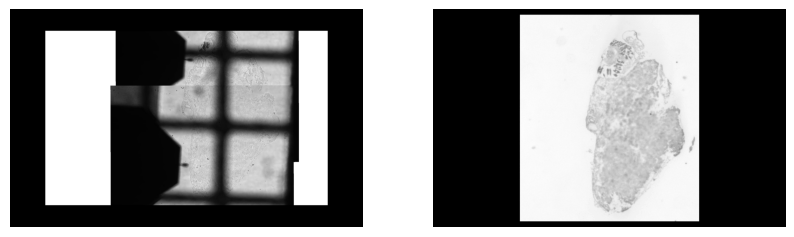

In [18]:
# Load the two .tif images
image1 = cv2.imread('./image_dir/matched_cropped_afm.tif', cv2.IMREAD_GRAYSCALE)

image2 = cv2.imread('./image_dir/matched_cropped_visium.tif', cv2.IMREAD_GRAYSCALE)




# Zoom into the center of resized_img2
zoomed_img2 = zoom_in_center(image2, zoom_factor=2)

zoomed_out_img1 = zoom_out(image1, zoom_factor=1.25)

# Resize the images without adding black borders
resized_img1, resized_img2 = place_on_canvas(zoomed_out_img1, zoomed_img2)

# Assuming spift_img1 and spift_img2 are already defined (e.g., after edge detection or preprocessing)
spift_img1 = apply_blur_and_edges(resized_img1, 20, 10)
spift_img2 = apply_blur_and_edges(resized_img2, 20, 10)


# Display the cropped and resized images for verification
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(resized_img1, cmap='gray')
plt.axis('off')  # Removes axis labels

plt.subplot(1, 2, 2)
plt.imshow(resized_img2, cmap='gray')
plt.axis('off')  # Removes axis labels
plt.show()


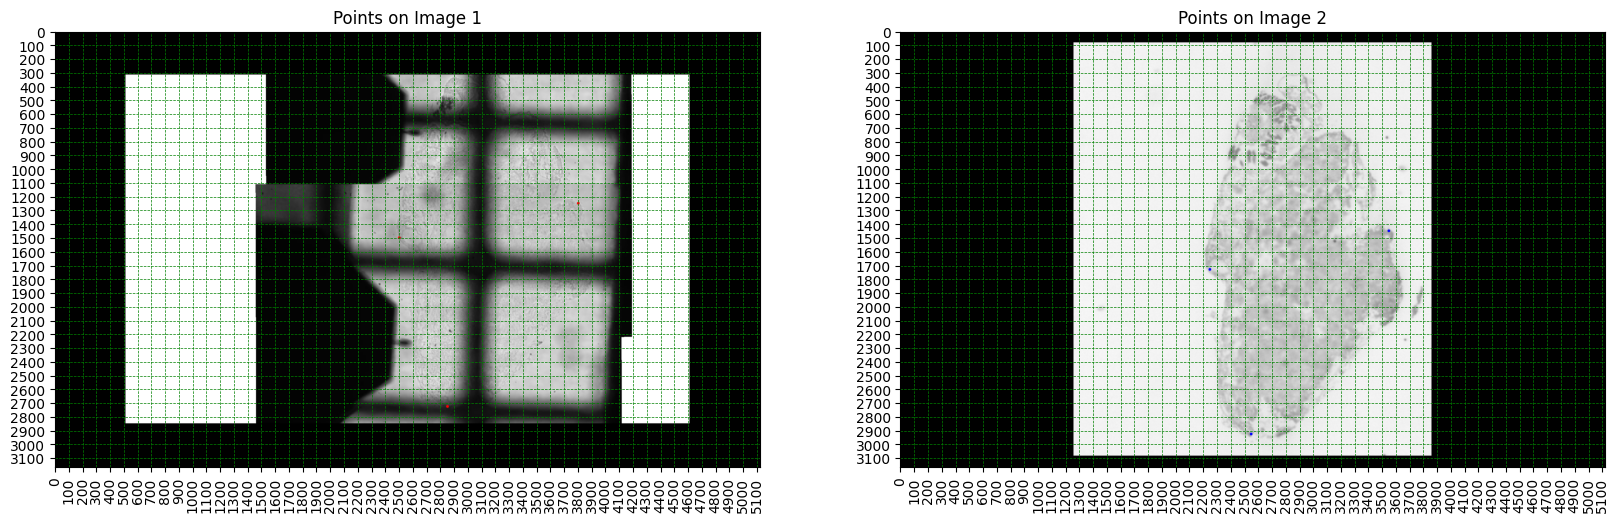

In [19]:
# Example of manually defining corresponding points
points_img1 = [(2500, 1500), (3800, 1250), (2850, 2725)]  # Replace with actual points on resized_img1
points_img2 = [(2250, 1730), (3550, 1450), (2550, 2925)]  # Replace with actual points on resized_img2

# Plot the points for easier definition
plot_points_on_images(resized_img1, resized_img2, points_img1, points_img2)

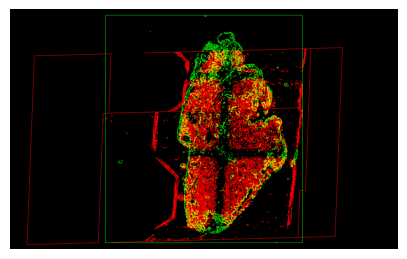

In [20]:
# Apply manual registration

def manual_registration(img1, img2, points_img1, points_img2):
    # Convert points to numpy arrays
    pts_img1 = np.array(points_img1, dtype=np.float32)
    pts_img2 = np.array(points_img2, dtype=np.float32)
    
    # Compute the affine transformation matrix
    affine_matrix = cv2.getAffineTransform(pts_img1, pts_img2)
    
    # Apply the affine transformation to img1
    aligned_img1 = cv2.warpAffine(img1, affine_matrix, (img2.shape[1], img2.shape[0]))
    
    return aligned_img1

aligned_img1 = manual_registration(spift_img1, spift_img2, points_img1, points_img2)

composite_result = composite_images([aligned_img1, spift_img2])

# Display the composite image
plt.figure(figsize=(5, 5))
plt.imshow(composite_result, cmap='gray')
plt.axis('off')
plt.show()


In [21]:



# Generate min/max bounds from the manual points
min_x, max_x, min_y, max_y = generate_bounds_from_manual_points(points_img1, margin=0)

# Call the function with the images, manual registration points, and bounds
random_points_img1, mapped_points_img2, distances = generate_pseudo_random_point_pairs(
    spift_img1, spift_img2, points_img1, points_img2, min_x, max_x, min_y, max_y, num_pairs=10)
random_points_img1



alignment_scores = {
    'starting_points': random_points_img1,
    'manual': mapped_points_img2
}

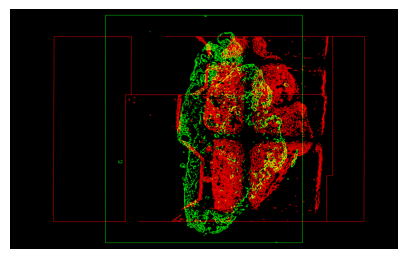

In [22]:
# Apply manual registration
aligned_img1 = manual_registration(spift_img1, spift_img2, points_img1, points_img2)

composite_result = composite_images([aligned_img1, spift_img2])


# Register using Elastix
elastix_registered_img = register_elastix(resized_img1, resized_img2)

elastix_registered_img, elastix_transform_parameters, affine = register_elastix(resized_img1, resized_img2)


# Apply the transformation to spift_img1 using the same transform parameters
transformed_spift_img1 = apply_elastix_transform(spift_img1, spift_img2.shape, elastix_transform_parameters)

# Create a composite image with the transformed spift_img1 and spift_img2
composite_result = composite_images([transformed_spift_img1, spift_img2])

# Display the composite image
plt.figure(figsize=(5, 5))
plt.imshow(composite_result, cmap='gray')
plt.axis('off')
plt.show()


In [8]:


# Assuming resized_img1, resized_img2, random_points_img1, and mapped_points_img2 are defined
result_image, result_transform_parameters, affine_parameters = register_elastix(resized_img1, resized_img2)

# Step 2: Apply the affine transformation to the random points from img1
transformed_random_points_img1 = apply_affine_transform_to_points(random_points_img1, affine_parameters)
alignment_scores['itk'] = transformed_random_points_img1
# Step 3: Compute the MSE between the transformed points and the mapped points from img2
mse_value = compute_mse(transformed_random_points_img1, mapped_points_img2)

# Output the MSE value
print(f"Mean Squared Error (MSE) between transformed random points and mapped points: {mse_value}")


Mean Squared Error (MSE) between transformed random points and mapped points: 36360.79853765315


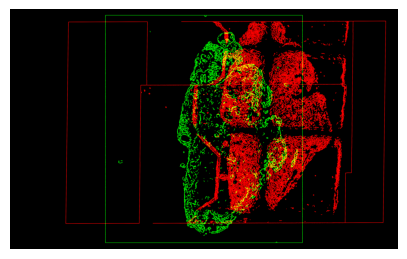

Mean Squared Error (MSE) between transformed random points and mapped points: 141083.80720269712


In [9]:
# Call the function with your images
#register_and_transform(resized_img1, resized_img2, spift_img1, spift_img2)
def register_and_transform_ants_with_points(fixed_img, moving_img, spift_img1, spift_img2, points):
    """
    Register two images (fixed and moving), apply the resulting transformation to spift_img1 and a set of points,
    and composite the transformed spift_img1 with spift_img2.
    
    Parameters:
    - fixed_img: The fixed image to be used for registration.
    - moving_img: The moving image to be aligned to the fixed image.
    - spift_img1: The image to be transformed based on the registration result.
    - spift_img2: The second image for compositing.
    - points: A list of 10 (x, y) points to be transformed.
    
    Returns:
    - transformed_spift_img1: Transformed version of spift_img1.
    - transformed_points: Transformed coordinates of the given points.
    - composite_img_spift: The composite image of the transformed spift_img1 and spift_img2.
    """
    
    # Register resized_img1 and resized_img2 using ANTs registration
    fixed_ants = ants.from_numpy(fixed_img)
    moving_ants = ants.from_numpy(moving_img)
    
    # Perform registration using the affine transformation model
    reg = ants.registration(fixed=fixed_ants, moving=moving_ants, type_of_transform='Affine')
    
    # Apply the transformation to spift_img1 using the same registration parameters
    spift_ants = ants.from_numpy(spift_img1)
    transformed_spift_img1 = ants.apply_transforms(fixed=fixed_ants, moving=spift_ants, transformlist=reg['fwdtransforms'])
    
    # Apply the same transformation to the set of points
    points_df = pd.DataFrame(points, columns=['x', 'y'])  # Create a DataFrame for points
    points_df['z'] = 0  # Add a 'z' column because ANTs expects 3D points, set z=0 for 2D
    
    # Apply transformation to the points using the registered transform
    transformed_points_df = ants.apply_transforms_to_points(dim=3, points=points_df, transformlist=reg['fwdtransforms'])
    
    # Extract the transformed points (only x, y) from the resulting DataFrame
    transformed_points = transformed_points_df[['x', 'y']].values
    
    # Apply the transformation to spift_img1 using the same registration parameters
    transformed_spift_img1 = apply_transform_ants(reg, spift_img1)
    
    # Composite the transformed spift_img1 with spift_img2
    composite_img_spift = composite_images([transformed_spift_img1, spift_img2])    
    # Plot the composite image
    plt.figure(figsize=(5, 5))
    plt.imshow(composite_img_spift, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

    return transformed_spift_img1, transformed_points, composite_img_spift

img, pts_ants, comp = register_and_transform_ants_with_points(resized_img1, resized_img2, spift_img1, spift_img2, random_points_img1)
alignment_scores['ants'] = pts_ants

# Step 3: Compute the MSE between the transformed points and the mapped points from img2
mse_value = compute_mse(pts_ants, mapped_points_img2)

# Output the MSE value
print(f"Mean Squared Error (MSE) between transformed random points and mapped points: {mse_value}")



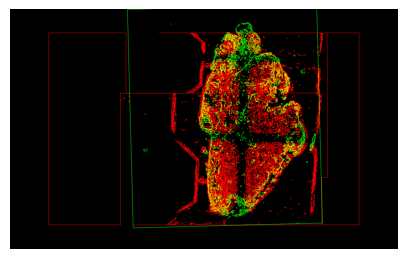

In [24]:


#spift_img1 = apply_blur_and_edges(resized_img1)
#spift_img2 = apply_blur_and_edges(resized_img2 )
import numpy as np
from pystackreg import StackReg



# Example usage



sr_scaled, comp_image_scaled, scaled_pts = register_pystackreg(spift_img1, spift_img2,random_points_img1, StackReg.SCALED_ROTATION)
sr_affine, comp_image_affine, affine_pts = register_pystackreg(spift_img2, spift_img1,random_points_img1, StackReg.AFFINE)
#sr_scaled, comp_image_scaled, scaled_pts = register_pystackreg(spift_img1, spift_img2)
#sr_affine, comp_image_affine, affine_pts = register_pystackreg(spift_img2, spift_img1)

alignment_scores['SPiFT'] = scaled_pts


plt.figure(figsize=(5,5))
plt.imshow(composite_images([spift_img1, comp_image_scaled]), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()


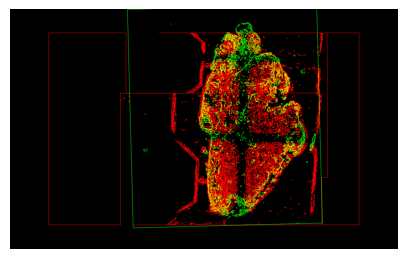

In [12]:

sr_scaled, comp_image_scaled, scaled_pts = register_pystackreg(spift_img1, spift_img2)

plt.figure(figsize=(5,5))
plt.imshow(composite_images([spift_img1, comp_image_scaled]), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()


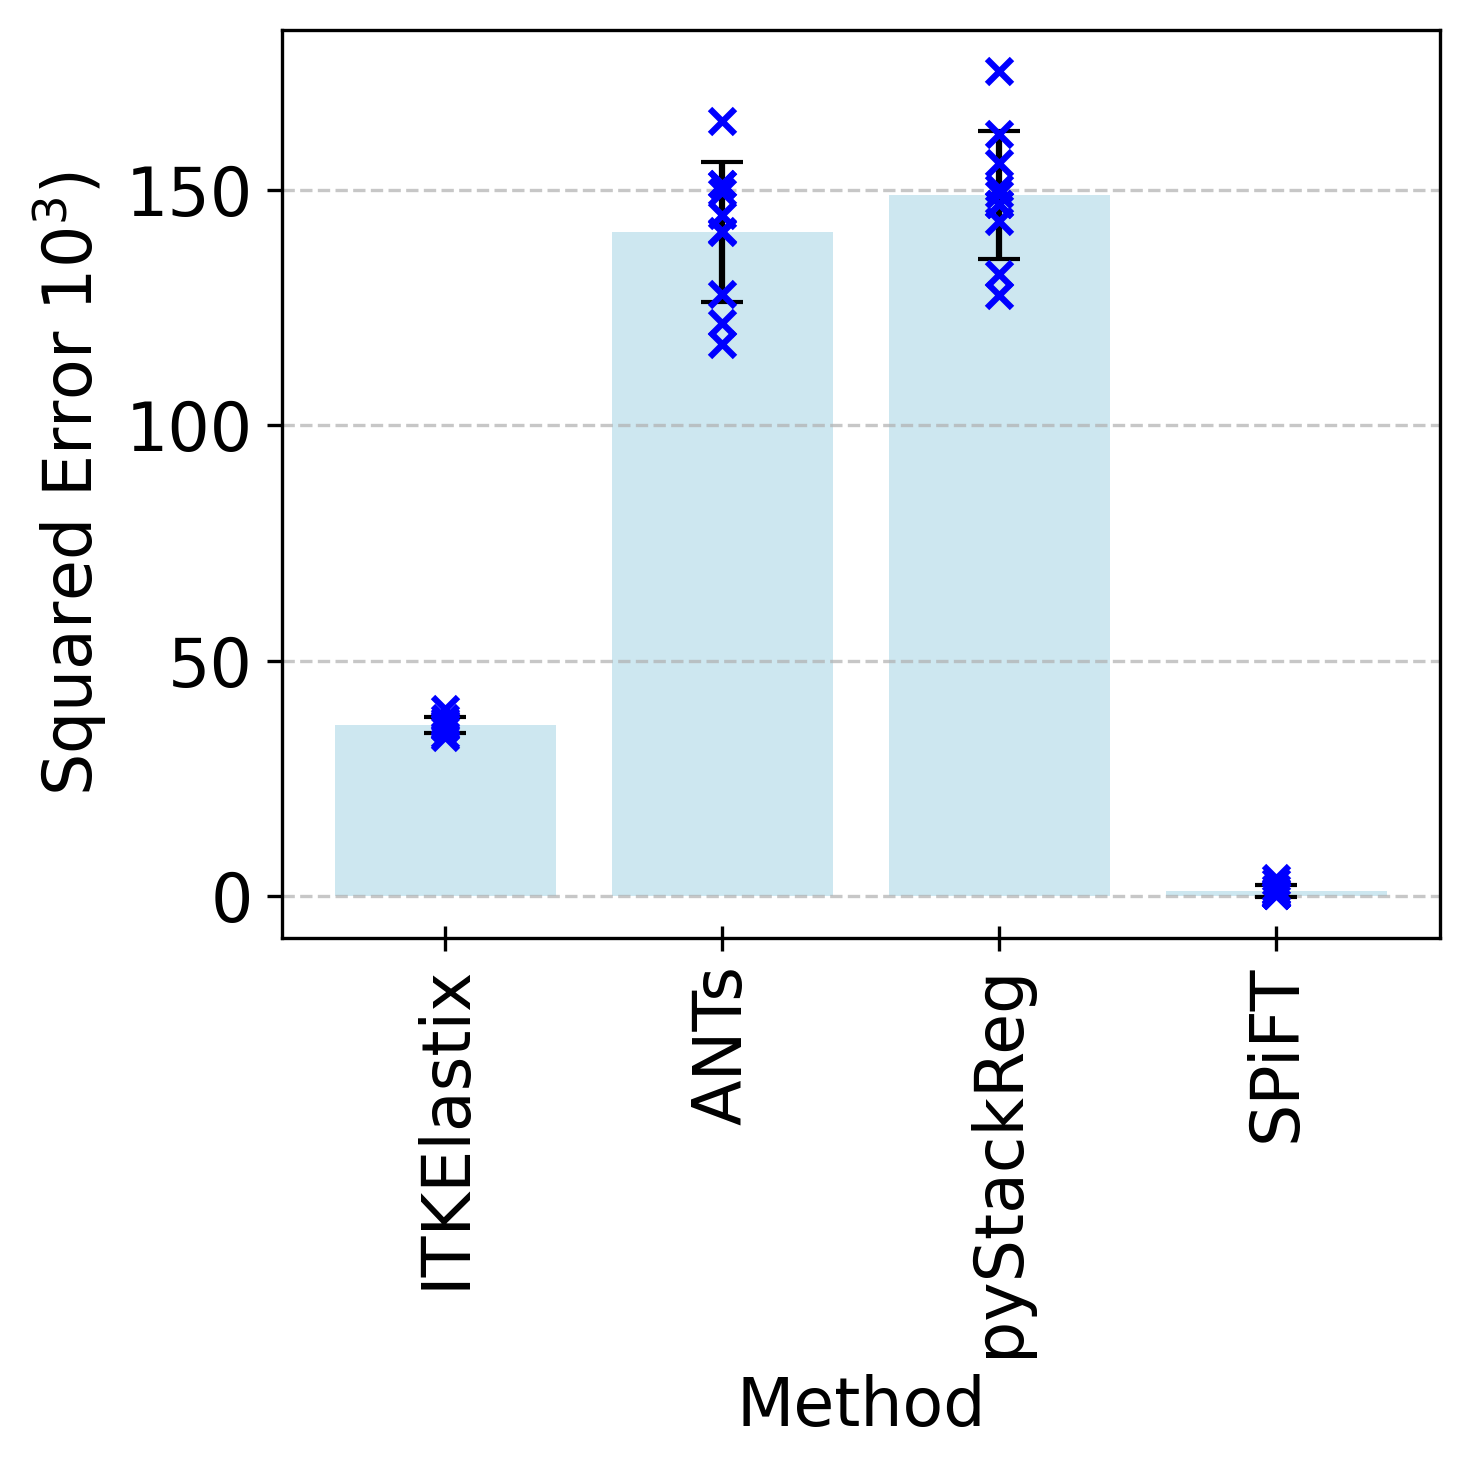

In [14]:
# Calculate MSE for each method
mse_results = {}
squared_errors = {}

for method, coords in alignment_scores.items():
    squared_error = np.square(coords - alignment_scores['manual'])
    mse = np.mean(squared_error)
    mse_results[method] = mse
    squared_errors[method] = squared_error

squared_errors_per_point = {method: np.mean(errors, axis=1) for method, errors in squared_errors.items()}

# Converting the squared error per point to a DataFrame for easier plotting
squared_error_points_df = pd.DataFrame(squared_errors_per_point)
squared_error_points_df = squared_error_points_df.drop("manual", axis = 1)
squared_error_points_df = squared_error_points_df.drop("starting_points", axis = 1)
squared_error_points_df.columns = ['ITKElastix', "ANTs", "pyStackReg", "SPiFT"]
squared_error_points_df.to_csv("error_alignment_scores.csv")

squared_error_points_df /= 1000

# Plotting the bar chart with dots
error_bars = squared_error_points_df.std()

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)  # High DPI for publication and thinner design

# Creating a bar plot for each method with error bars
bars = ax.bar(squared_error_points_df.columns, squared_error_points_df.mean(), yerr=error_bars, 
              color='lightblue', alpha=0.6, label='Mean Squared Error', capsize=5)

# Adding individual data points as scatter points using "x" markers
for method, col in squared_error_points_df.items():
    # Scatter plot for the individual squared errors of each point with 'x' markers
    ax.scatter([method] * len(col), col, color='blue', marker='x', zorder=5)

# Adding labels and titles
#ax.set_title('Mean Squared Erro', fontsize=14)
ax.set_ylabel('Squared Error $10^{3}$)', fontsize=16)
ax.set_xlabel('Method', fontsize=16)

# Adding x-tick marks and grid lines
ax.set_xticks(range(len(squared_error_points_df.columns)))  # Setting the x-ticks aligned with bars
ax.set_xticklabels(squared_error_points_df.columns, fontsize=16, rotation=90)  # Rotating x-ticks 90 degrees

# Adding grid lines only on the y-axis for clarity
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding x-tick marks
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='inout', length=6, labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Displaying the plot with the desired settings
plt.tight_layout()
plt.show()
